# Control Variate Technique for Binomial Tree Prices

### Motivation
This illustrates the use of the Control Variate technique for reducing the variance of an estimate for an option price calculated on a Binomial tree. See  https://en.wikipedia.org/wiki/Control_variates or Simulation by S.M. Ross for discussions of control variates in general. The application to pricing American Put options using the corresponding European option is discussed by 
Hull \& White in 'The Use of the Control Variate Technique in Option Pricing', J. of Finance, 42 (June 1987), 281-300; THE CONVERGENCE OF BINOMIAL TREES FOR PRICING
THE AMERICAN PUT M.Joshi 2008; and
[On the use and improvement of Hull and White’s control variate technique](https://scholars.lib.ntu.edu.tw/bitstream/123456789/165629/1/22.pdf)



Here we price an American option by using the corresponding European option which has an analytic expression for it's price given by the Black-Scholes formula. We first estimate the optimal coefficient, $c^*$ in the expression
$$Z\equiv A + c\thinspace(E - \mu_E)$$ so as to minimize it's variance: 
$$\mathbb{V}\text{ar}[Z] = \mathbb{V}\text{ar}[A] + c^2\mathbb{V}\text{ar}[E] +2c\thinspace\mathbb{C}\text{ov}[A,E]$$ $\ $
$$c^* = -\thinspace\mathbb{C}\text{ov}[A,E]\ /\ \mathbb{V}\text{ar}[E].$$ We then have $$E[Z] = E[A]$$ $$\mathbb{V}\text{ar}[Z] = \mathbb{V}\text{ar}[A] - (\mathbb{C}\text{ov}[A,E])^2\ /\ \mathbb{V}\text{ar}[E]$$ 
or:
$${\mathbb{V}\text{ar}[Z]\over \mathbb{V}\text{ar}[A]} = (1 - \text{Corr}^2[A,E])$$
By choosing $A, E$ as the price of the American, European option calculated on the binomial tree, and setting $\mu_E$ as the Black-Scholes price of the European option, $Z$ calculated from the binomial tree will estimate the price of the American option with reduced variance. 

Strictly speaking, this technique applies to sampling from a fixed distribution of random numbers. We estimate $c^*$ from sample estimates of $\mathbb{C}\text{ov}[A, E]$ and $\mathbb{V}\text{ar}[E]$ where $A, E$ are sample realizations drawn from that distribution. As applied in the above mentioned references, and here, $A, E$ are American and European option prices obtained from Binomial trees. A Binomial tree of a given number of timesteps, `N_steps`, produces a  single, completely deterministic price. One can easily imagine using the technique on option prices produced by a (fixed) Monte Carlo engine where each realized price is a random number drawn from the distribution produced by that MC engine (number of timesteps, $r, \sigma, T,...$ all fixed). Estimating c* from the first several realizations of $(A, E)$, then allows to construct $Z$ with the above properties on subsequent simulations from that same MC engine.

What is the distribution we are drawing $A, E$ from when the option prices are produced by Binomial trees? Following the previous authors, we let the number of time steps, `N_steps`[<sup id="fn1-back">1</sup>](#fn1), used in the construction of the binomial tree play the role of randomness, i.e., we estimate $c^*$, $\mathbb{C}\text{ov}[A,E], \mathbb{V}\text{ar}[E]$ from a 'sample' of trees having some range of `N_steps`. We imagine that by observing how $A, E$ covary, we can form the above $Z$, which will then have the same mean and smaller variance over this selected range of `N_steps`. Let's see how this works.







[<sup id="fn1">1</sup>](#fn1-back) only `N_steps` varies, all other parameters($S_o, r, T, K, \sigma, ...$) of the tree and option are fixed.




### Investigation

In [1]:
#include "option_pricing.hpp"
#include "option_pricing.cc"

In [2]:
// Create Amer and Euro option prices on binomial trees having several N_steps ranges:

#include <fstream>
#include <iomanip>

using namespace OptionPricing;
using std::cout;
using std::endl;
using std::valarray;


// Construct the Amer and Euro Put options for a particular parameter set:
double S_o = 40.0, r = 0.0488, q = 0.0;
double K = 40.0, T = 7 / 12., sigma = 0.2;
Asset underlying{ S_o, q, sigma };
Terms terms_amer_put{ Terms::Style::Amer, Terms::Type::Put, T, K };
Terms terms_euro_put{ Terms::Style::Euro, Terms::Type::Put, T, K };
Option amer_put(terms_amer_put, underlying);
Option euro_put(terms_euro_put, underlying);

// Write to file their prices on the training set of binomial trees having N_steps on [20, 100]:
bool get_greeks = false;
constexpr int start_N = 20, end_N = 100;
constexpr int N_points{ end_N - start_N + 1 }; // Number of training points.
std::fstream outfile("prcs_20-100.csv", std::ios_base::out);
for (int N_steps = start_N; N_steps < end_N + 1; ++N_steps) {
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    double e = euro_put.btree_prc(N_steps, r, get_greeks);
    outfile << N_steps << "," << std::setprecision(12) << a << ',' << e << "\n";
}
outfile.close();

// Write to another file their prices on some other set of binomial trees:
int test_start_N = 4000;
int test_end_N = 4000 + N_points - 1;
outfile.open("prcs_4000-4080.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    double e = euro_put.btree_prc(N_steps, r, get_greeks);
    outfile << N_steps << "," << std::setprecision(10) << a << ',' << e << "\n";
}
outfile.close();


// Write to another file their prices on some other set of binomial trees:
test_start_N = 8000;
test_end_N = 8000 + N_points - 1;
outfile.open("prcs_8000-8080.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    double e = euro_put.btree_prc(N_steps, r, get_greeks);
    outfile << N_steps << "," << std::setprecision(10) << a << ',' << e << "\n";
}
outfile.close();

// write Amer, Euro and Optimal prices for N_steps on [1000, 20000]:
outfile.open("prcs_1000-20000.csv", std::ios_base::out);
for (int N_steps = 1000; N_steps < 20002; ++N_steps) {
    if (N_steps % 1000 < 2) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        double e = euro_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << a << ',' << e << ',' << a - c * (e - BS_prc) << endl;
        // cout << N_steps << ' ' << std::setprecision(10) << a - c * (e - BS_prc) << endl;
        // cout << N_steps << ' ' << std::setprecision(10) << a << endl;
    }
}
outfile.close();  

To run this Jupyter Notebook, the kernel must now be switched from C++14 to Python 3. In the menu above, click `Kernel` then `Change kernel`.

BS_prc: 1.8812198652840362


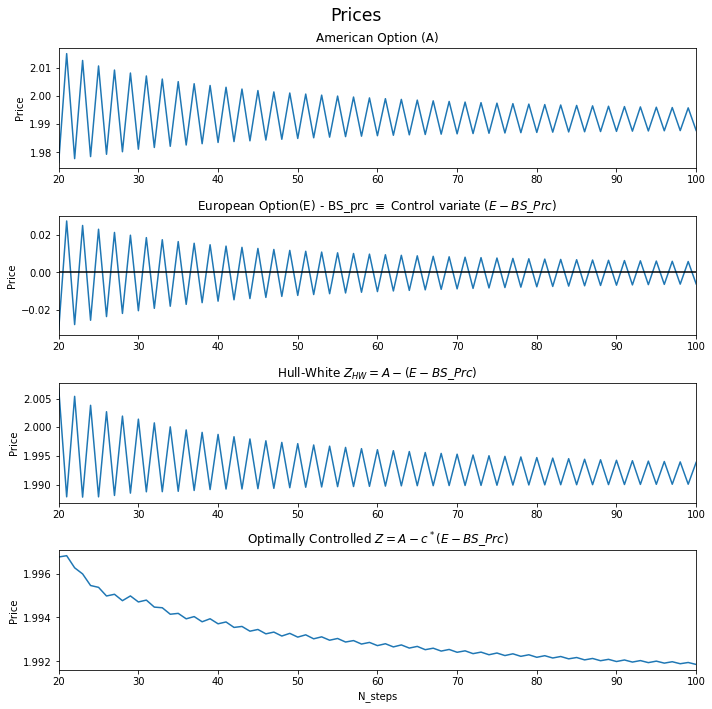

Over Binomial trees with `N_steps` on [20,100]:
Optimal Control Variate coefficient c*: 0.6697
Corr^2[A, E]: 0.98206
Variance | stddev of A:    8.175e-05 | 0.0090
Variance | stddev of Z_HW: 2.100e-05 | 0.0046
Variance | stddev of Z:    1.467e-06 | 0.0012
Mean A | Mean E - BS_prc:     1.992745 | -0.0006232


In [1]:
# Read in the American, European option prices, plot them, find Var[A], Cov[A,E] and c*.
# Form Z = A - c* (E - BS_Prc):
import numpy as np
import math
import matplotlib.pyplot as plt

N_steps, a, e = np.loadtxt("prcs_20-100.csv", delimiter=',', unpack=True)

# Calculate the Black-Scholes price for Euro option:
S_o = 40.0
r = 0.0488
q = 0.0
K = 40.0
T = 7 / 12
sigma = 0.2

d_1 = (math.log(S_o / K) + (r - q + sigma**2 / 2) * T) / (sigma * math.sqrt(T))
d_2 = d_1 - sigma * math.sqrt(T)
BS_prc = np.exp(-r * T) * K * math.erfc(d_2 / math.sqrt(2)) / 2 - S_o * math.erfc(d_1 / math.sqrt(2)) / 2;
print(f"BS_prc: {BS_prc}")

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)
corr_A_E_2 = c * c * cov_A_E[1,1] / var_A

# Plot them:
ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

# Look at the Vars and means on this interval of N_steps: 
print(f"Over Binomial trees with `N_steps` on [20,100]:")
print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Corr^2[A, E]: {corr_A_E_2:.5}")
      
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.4f}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.4f}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.4f}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.6f} | {(e-BS_prc).mean():10.7f}")


$A$ and $E$ each exhibit an alternating series property wrt `N_steps`. The size of these alternating up/down steps is decreasing. The variance of $Z_{HW}$ is larger than that of $Z$. 
The ratio $${\mathbb{V}\text{ar}[Z]\over \mathbb{V}\text{ar}[A]}= {1.467\cdot10^{-06}\over 8.175\cdot10^{-05}} = 0.01794$$ agrees with the expected $(1 - Corr^2[A, E]) = 1 - 0.98206$ for this training set (`N_steps` on [20, 100]).
If `N_steps` was not an ordered set we could safely say that $Z$ estimates $A$ better than $Z_{HW}$ does, but in reality, we can't, because, while removing most of the pairwise alternating character of the series, it leaves(exposes) the serial dependence of $A$ on `N_steps`. Let's continue to larger trees.

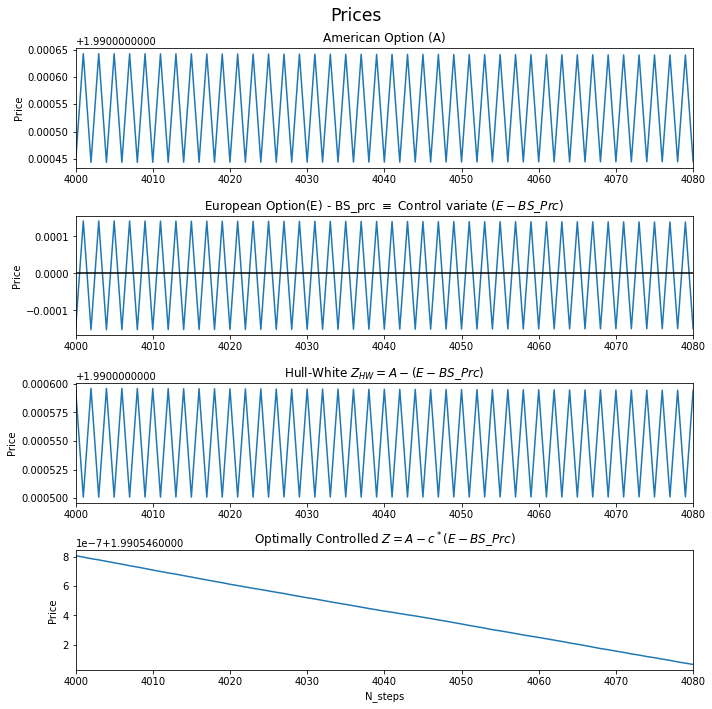

Optimal Control Variate coefficient c*: 0.6767
Variance | stddev of A:    9.845e-09 | 9.922e-05
Variance | stddev of Z_HW: 2.247e-09 | 4.740e-05
Variance | stddev of Z:    4.677e-14 | 2.163e-07
Mean A | Mean E - BS_prc:     1.990542 | -0.0000071


In [2]:
# Repeat for N_steps on [4000, 4080]:

N_steps, a, e = np.loadtxt("prcs_4000-4080.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.6f} | {(e-BS_prc).mean():10.7f}")

The alternating character continues. It is hard to see it's amplitude decreasing, but it is. The variance of $Z$ is again lower than $Z_HW$. Notice that the mean $A$ is decreasing. So while the control variate technique does an excellent job of exposing the serial trend, and if we could randomly order the `N_steps` parameter on the interval it would do a good job of reducing the variance of THE true/mean $A$, we realize $Z$ doesn't help to determine the true $A$ since this largely depends on `N_step`.

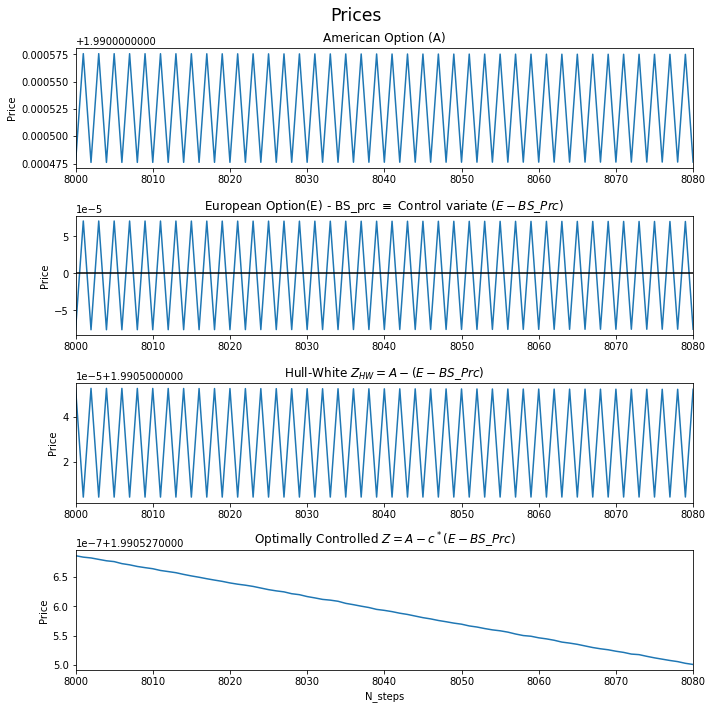

Optimal Control Variate coefficient c*: 0.6767
Variance | stddev of A:    2.486e-09 | 4.986e-05
Variance | stddev of Z_HW: 5.673e-10 | 2.382e-05
Variance | stddev of Z:    3.039e-15 | 5.513e-08
Mean A | Mean E - BS_prc:     1.990525 | -0.0000036


In [3]:
# Repeat for N_steps on [8000, 8080]:
N_steps, a, e = np.loadtxt("prcs_8000-8080.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.6f} | {(e-BS_prc).mean():10.7f}")


Notice how much less variance there is in $Z$ compared with $A$ or $Z_{HW}$. The vertical scale is two orders of magnitude smaller. But how much lower do $Z$ and $A$ go as N_step $\rightarrow \infty$? It would be good to have lower bounds.

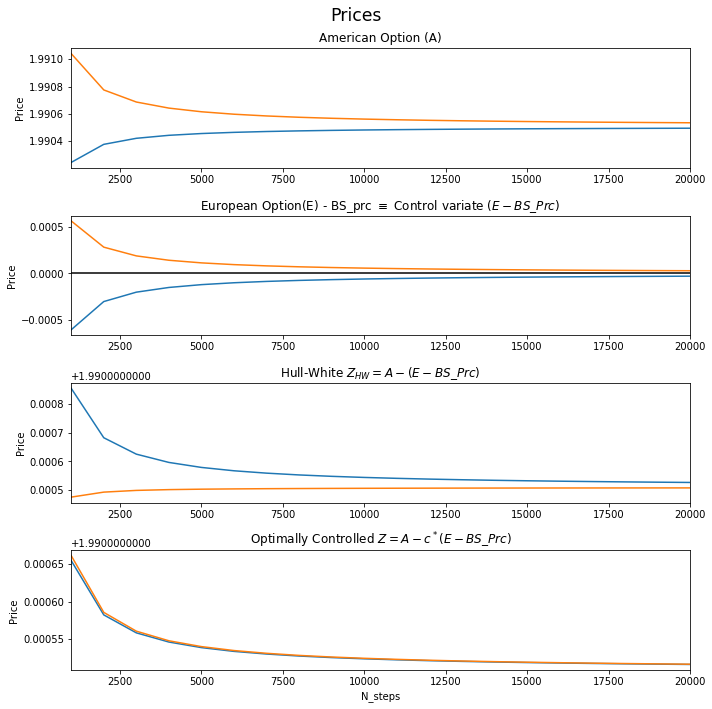

Optimal Control Variate coefficient c*: 0.671
Variance | stddev of A:    1.386e-08 | 1.177e-04
Variance | stddev of Z_HW: 4.159e-09 | 6.449e-05
Variance | stddev of Z:    1.087e-09 | 3.297e-05


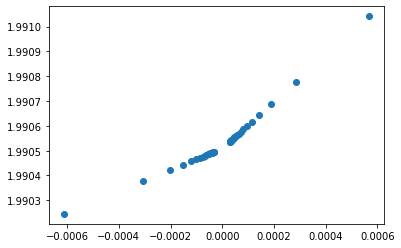

In [4]:
# Repeat for N_steps on [1000, 20001]:

N_steps, a, e = np.loadtxt("prcs_1000-20000.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps[::2], a[::2])
ax[0].plot(N_steps[1::2], a[1::2])
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps[::2], e[::2] - BS_prc)
ax[1].plot(N_steps[1::2], e[1::2] - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps[::2], z_HW[::2])
ax[2].plot(N_steps[1::2], z_HW[1::2])
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps[::2], z[::2])
ax[3].plot(N_steps[1::2], z[1::2])
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
# Scatter plot of A vs E - BS_prc:
fig, ax = plt.subplots()
ax.scatter(e - BS_prc, a)


Above are plotted the upper and lower envelopes of the alternating series $A$, $E - BS\_prc, Z_{HW}$ and $Z$. For any fixed interval of `N_steps`, the variance of $A$, $E$ and $Z_{HW}$ is dominated by the alternating, while that of $Z$ by the serial drift. The problem with using $Z$ to estimate the true $A$ is that it continues drifting lower. This is consistent with the fact that, as we moved the `N_steps` window to larger valuse, the mean of $A$ has been falling while the mean of $E-BS\_prc$ has been rising, so that the mean of $Z=A - c^*(E-BS\_prc)$ (between these windows) has fallen; with optimal $c^*$ we have removed the alternation and we are left with these falling means.



### An Alternative

We are looking for a fast, accurate estimation of the $\lim_{n\to \infty}A$. To this end, we calculate A from the binomial trees at several consecutive values of `N_steps`, read them into python and explore convergence:

In [ ]:
// Write several pairs of America option prices to a file:
#include "option_pricing.hpp"
#include "option_pricing.cc"
#include <fstream>
#include <iomanip>

using namespace OptionPricing;
using std::cout;
using std::endl;
using std::valarray;


// Construct the Amer and Euro Put options for a particular parameter set:
double S_o = 40.0, q = 0.0;
double K = 40.0, T = 7 / 12., sigma = 0.2;
Asset underlying{ S_o, q, sigma };
Terms terms_amer_put{ Terms::Style::Amer, Terms::Type::Put, T, K };
Option amer_put(terms_amer_put, underlying);

// Write to file their prices on pairs of binomial trees to probe convergence:
bool get_greeks = false;
double r = 0.0488;
std::fstream outfile_low("prcs_low_cluster.csv", std::ios_base::out);
std::fstream outfile_high("prcs_high_cluster.csv", std::ios_base::out);
for (int n=5; n < 10; ++n) {
    int N_steps = std::pow(4, n);
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    outfile_low << N_steps << "," << std::setprecision(12) << a << "\n";
    a = amer_put.btree_prc(N_steps+1, r, get_greeks);
    outfile_high << N_steps+1 << "," << std::setprecision(12) << a << "\n";
}   
outfile_low.close();
outfile_high.close();

// Write to another file 5 low/high pairs on N_steps [1024, 1034]: 
outfile_low.open("prcs_1024_cluster.csv", std::ios_base::out);  // re-use outfile_low.
for (int n=1024; n < 1034; ++n) {
    double a = amer_put.btree_prc(n, r, get_greeks);
    outfile_low << n << "," << std::setprecision(12) << a << "\n";
}
outfile_low.close();

Text(0, 0.5, 'Price')

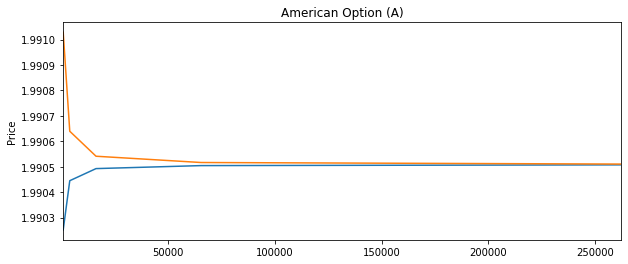

In [8]:
# Read in the paired american option prices and plot:
import numpy as np
import matplotlib.pyplot as plt

N_steps_lows, lows = np.loadtxt("prcs_low_cluster.csv", delimiter=',', unpack=True)
N_steps_highs, highs = np.loadtxt("prcs_high_cluster.csv", delimiter=',', unpack=True)

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(N_steps_lows, lows)
ax.plot(N_steps_highs, highs)
ax.set_title("American Option (A)")
ax.set_xlim(N_steps_lows[0], N_steps_highs[-1])
ax.set_ylabel('Price')


In [9]:
N_steps_highs, N_steps_lows, highs, lows

(array([  1025.,   4097.,  16385.,  65537., 262145.]),
 array([  1024.,   4096.,  16384.,  65536., 262144.]),
 array([1.99102904, 1.99063959, 1.99054134, 1.99051666, 1.99051048]),
 array([1.99025152, 1.9904451 , 1.99049271, 1.9905045 , 1.99050744]))

We see that these have nice 'pinching' convergence property. For any pair of pairs, (L,H), (l,h), for example (1.99102904, 1.99025152) at 1024, 1025 and (1.99051048, 1.99050744) at 262144, 262145, we iterate to convergence to find limiting $\alpha$ from $x_i = l + \alpha_i*(h-l) = L + \alpha_{i+1}(H-L)$, 
$$ \alpha_i = {x_{i-1}-L\over H-L},\ \ \ \  x_0 =0.5$$
This scheme is based on a guess that the above plot of A vs `N_steps` is self-similar, that for any value of `N_steps` the true option price lies the same fraction of the way from L to H, the ratio of {the distance from the bottom blue curve to the horizontal line representing the true option price} to {the distance from the bottom blue line to the top orange curve}, $\alpha$, is constant independent of `N_steps`. Self-similarity is confirmed by the constance of the (high - low) gap ratio between `N_steps` points pairs, i.e., $$(\text{highs}[i]-\text{lows}[i])\ /\ (\text{highs}[i+j] - \text{lows}[i+j]) = k(j)$$
, e.g.,
$${1.99102904 - 1.99025152\over 1.99063959 - 1.9904451} = 3.9977,\ \ \  i, j = 0, 1\newline$$ 
$${1.99063959 - 1.9904451 \over 1.99054134 - 1.99049271} = 3.99938, \ \ \ \ i, j = 1, 2\newline$$ 
$${1.99054134 - 1.99049271 \over 1.99051048 - 1.99050744} = 15.9967 \approx 4^2 = 16, \ \ \ \ i, j = 2, 4\ \  etc.\newline $$
The gap ratio between succesive steps is the same as the `N_steps` ratio between those same steps! ($=4$) 

In [10]:
def get_alpha_lim(L, H, l, h):
    delta = h - l  # gap from upper to lower price bound envelopes at the large N_steps pair (the right gap).
    Delta = H - L  # (the larger) gap from upper to lower price bound envelopes at the small N_steps pair (left gap)
    alpha_prev = 0
    alpha = 0.5    # Start with true A price in middle of the right gap.
    while not np.isclose(alpha_prev, alpha):
        x = l + alpha * delta
        alpha_prev = alpha
        alpha = (x - L) / Delta   # See what alpha this implies at the left gap, and iterate.
    return alpha, alpha - alpha_prev

Calculating the limiting $\alpha_\infty$ and corresponding limiting option prices, x, confirms $\alpha_\infty$ is constant, the convergence envelope is self-similar:

In [11]:
# get limiting alpha for each pair of (low,high) points paired up with each pair of (low,high) points to the right:
print("i, j   alpha_lim   x_lim")
for i in range(len(lows)):
    for j in range(i+1, len(lows)):
        alpha_lim, delta_alpha = get_alpha_lim(lows[i], highs[i], lows[j], highs[j])
        print(f"{i}, {j}: {alpha_lim:10.7f}  {lows[i] + alpha_lim * (highs[i] - lows[i]):12.9f}")



i, j   alpha_lim   x_lim
0, 1:  0.3320215   1.990509673
0, 2:  0.3308971   1.990508798
0, 3:  0.3305364   1.990508518
0, 4:  0.3304358   1.990508440
1, 2:  0.3264052   1.990508580
1, 3:  0.3257899   1.990508460
1, 4:  0.3256090   1.990508425
2, 3:  0.3233312   1.990508430
2, 4:  0.3230637   1.990508417
3, 4:  0.3219961   1.990508414


Maybe average a few consecutive lows and the highs at the left end gives better accuracy:

In [12]:
# Read in 5 low/high pairs of A, N_steps on [1024, 1033]:  
N_steps_1024, a = np.loadtxt("prcs_1024_cluster.csv", delimiter=',', unpack=True)

a[::2], a[1::2]

(array([1.99025152, 1.99025201, 1.99025252, 1.99025303, 1.99025354]),
 array([1.99102904, 1.99102803, 1.99102703, 1.99102604, 1.99102505]))

In [13]:
L, H = a[::2].mean(), a[1::2].mean()
L, H

(1.9902525239639999, 1.99102703671)

In [14]:
# Get limiting alpha between this averaged left end point and the extreme right end point:
alpha_lim, delta_alpha = get_alpha_lim(L, H, lows[len(lows)-1], highs[len(lows)-1])
alpha_lim, L + alpha_lim * (H - L)

(0.33042167196394506, 1.9905084397604906)

In [15]:
# Using this limiting alpha, calculate limiting x at right end point:
lows[len(lows)-1] + alpha_lim * (highs[len(lows)-1] - lows[len(lows)-1])

1.9905084397525816

### Summary
We saw that by using the price of the corresponding European option as a control variate, we can lower the variance of prices calculated for an American option on a range of binomial trees. However there remains a serial drift that may lead to trouble with this approach.

By plotting the prices of the American Put option for binoomial trees over a wide range of the `N_steps` parameter, we found a way to get accurate an accurate price from smaller trees.
Calculating option prices on a consecutive `N_steps` pair of trees at large `N_steps`, iterating for $\alpha_\infty$ between this pair and a left end point pair(or better average of several consecutive pairs for left end point), provides an accurate option price from $L + \alpha_\infty (H - L)$.

I would think that $\alpha_\infty$ would depend on the parameters of the option being priced. But then the appearance of the number $4=k(1)$ above would be pure coincidence. This suggests that we have stumbled upon a way to bypass the construction of large binomial trees for accurate option prices universally applicable to American Puts.

See: [Asymptotics of the binomial formula for option pricing](http://math.unice.fr/~diener/crr/crreng.ps)

### Next Steps
The following shows the behavior of a not at the money American Put:

In [1]:
// Note: must run this cell with fresh c++14 kernel.
#include "option_pricing.hpp"
#include "option_pricing.cc"

#include <fstream>
#include <iomanip>

using namespace OptionPricing;
using std::cout;
using std::endl;
using std::valarray;


// Construct the Amer and Euro Put options for a particular parameter set:
double S_o = 50.0, r = 0.0488, q = 0.0;
double K = 40.0, T = 7 / 12., sigma = 0.2;
Asset underlying{ S_o, q, sigma };
Terms terms_amer_put{ Terms::Style::Amer, Terms::Type::Put, T, K };
Option amer_put(terms_amer_put, underlying);
bool get_greeks {false};

// Write to another file their prices on some other set of binomial trees:
int test_start_N = 1000;
int test_end_N = 1000 + 100 - 1;
std::fstream outfile("prcs_1000.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    outfile << N_steps << "," << std::setprecision(10) << a <<"\n";//<< ',' << e << "\n";
}
outfile.close();
/*
test_start_N = 2000;
test_end_N = 2000 + 100 - 1;
outfile.open("prcs_2000.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << std::setprecision(10) << a << "\n"; //<< ',' << e << "\n";
}
outfile.close();
test_start_N = 4000;
test_end_N = 4000 + 100 - 1;
outfile.open("prcs_4000.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    if (N_steps % 4 == 0) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << std::setprecision(10) << a << "\n"; //<< ',' << e << "\n";
    }
}

outfile.close();

test_start_N = 16000;
test_end_N = 16000 + 200 - 1;
outfile.open("prcs_16000.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    if (N_steps % 4 == 0) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << std::setprecision(10) << a << "\n"; //<< ',' << e << "\n";
    }
}
outfile.close();
*/

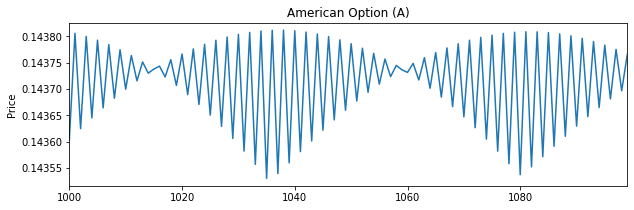

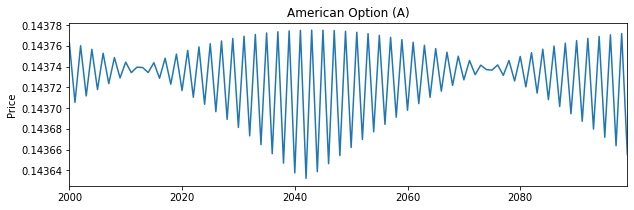

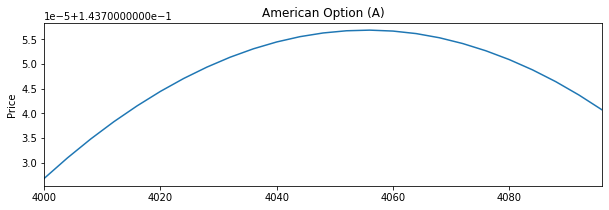

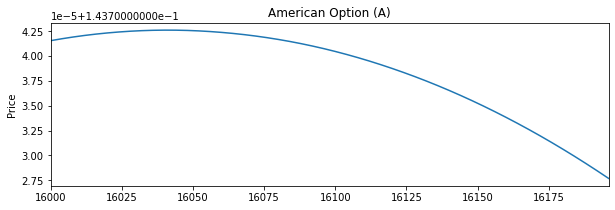

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt

N_steps, a = np.loadtxt("prcs_1000.csv", delimiter=',', unpack=True)
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(N_steps, a)
ax.set_title("American Option (A)")
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_ylabel('Price')
plt.show()

N_steps, a = np.loadtxt("prcs_2000.csv", delimiter=',', unpack=True)
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(N_steps, a)
ax.set_title("American Option (A)")
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_ylabel('Price')
plt.show()

N_steps, a = np.loadtxt("prcs_4000.csv", delimiter=',', unpack=True)
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(N_steps, a)
ax.set_title("American Option (A)")
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_ylabel('Price')
plt.show()

N_steps, a = np.loadtxt("prcs_16000.csv", delimiter=',', unpack=True)
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(N_steps, a)
ax.set_title("American Option (A)")
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_ylabel('Price')
plt.show()


This price vs `N_steps` behavior is more complex than the alternating series at the money. Note that in the last 2 plots only every 4th step is plotted, these are highs. Next step is to locate the local max and mins to be able to characterize the envelope and then again look at the asymptotic behavior to see if a simple relation exist among American Put options.